In [1]:
%pylab notebook
from unittest.mock import MagicMock, Mock
from time import sleep
#from qutip import *
class DataGen:
    
    def __init__(self):
        self._counter = 0
        self._nop = 1
        self._freq = 0.1
        
    def fun(self, x):
        return [cos(self._freq*x) + 1j*cos(self._freq*x)]*self._nop
    
    def get_sdata(self):
        retval = self.fun(self._counter)
        self._counter += 1
        sleep(0.2)
        return retval
    
    def get_frequencies(self):
        return linspace(self._freq_limits[0], self._freq_limits[1], self._nop)
    
    def set_parameters(self, params):
        self._nop = params["nop"]
        self._freq_limits = params["freq_limits"]
    
    def set_freq_limits(self, *limits):
        self._freq_limits = limits
        
    def set_nop(self, nop):
        self._nop = nop
        
    def detect(self):
        return 5.9e9, 0, 0
    
dg = DataGen()
vna = Mock()
cur_src = Mock()
q_lo = Mock()
q_awg = Mock()
ro_awg = MagicMock()
q_z_awg = Mock()
q_lo_2 = Mock()
q_awg_2 = Mock()
ro_awg_2 = MagicMock()
mw_src = Mock()
RD = Mock()
RD.detect = dg.detect
vna.get_sdata = dg.get_sdata
vna.set_parameters = dg.set_parameters
vna.get_frequencies = dg.get_frequencies
vna.set_freq_limits = dg.set_freq_limits
vna.set_nop = dg.set_nop


Populating the interactive namespace from numpy and matplotlib


# CZ tests

In [2]:
params = [1, -0.09, 0]
duration = 150
waveform_resolution = 1
offset_voltage = 5
zero_offset = 1

offset = zero_offset + offset_voltage
N_time_steps = int(round(duration / waveform_resolution))

X = linspace(0, duration, N_time_steps + 1)
components = [params[n] * (1 - cos(2*pi*X*(n+1)/duration)) for n in range(len(params))]
waveform = sum(components, axis=0) * offset_voltage
waveform -= min(abs(waveform)) * sign(offset_voltage)
waveform += zero_offset
plt.plot(waveform)

# Tomo Joint

In [2]:
from lib2.DispersiveJointTomography import *
prep_pulses = [["-X/2","-X/2","+Z/2"],
               ["-X/2","-X/2","+Z/2"]
              ]
DJT = DispersiveJointTomography('tomo joint', 'lol', 
                        vna=[vna], q_lo=[q_lo, q_lo], q_awg=[q_awg, q_awg], ro_awg=[ro_awg], q_z_awg=[q_z_awg, q_z_awg])
vna_parameters = {"bandwidth":10, "freq_limits":[6e9]*2, "nop":20, "averages":1}
exc_frequency = 5e9
q_freq = 5e9
hpi = 1
sequence_parameters = {"awg_trigger_reaction_delay":0, "readout_duration":3e3,
                       "repetition_period": 15000, "modulating_window":"rectangular", "pulse_length": 200,
                       "pulse_pi_amplitudes": [hpi*2, hpi*2], 'padding':10, "tomo_delay": 10,
                       "prep_pulses":prep_pulses, "z_pulse_offset_voltages": [.1, .1], "z_pulse_duration": 17.4, 
                       "z_smoothing_coefficient":2}
ro_awg_params =  {"calibration":MagicMock()}
q_awg_params = {"calibration":MagicMock()}
q_z_awg_params = {"calibration":MagicMock()}
q_lo_params = {'power':-10, 'frequency':q_freq + 100e6}
dev_params = {'vna':[vna_parameters], 
              'ro_awg':[ro_awg_params], 
              'q_awg':[q_awg_params, q_awg_params],
              'q_z_awg':[q_z_awg_params, q_z_awg_params],
              'q_lo':[q_lo_params, q_lo_params]}

tomo_local_rotations = [('+I', '+I'),
                        ('+I', '+X/2'),
                        ('+I', '+Y/2'),
                        ('+I', '+X'),
                        ('+X/2', '+X/2'),
                        ('+Y/2', '+Y/2'),
                        ('+X', '+X')
                        ,('+X/7','+X')
                       ]
betas = (10,2,2,7)

DJT.set_fixed_parameters(sequence_parameters, betas, **dev_params)
DJT.set_swept_parameters(tomo_local_rotations)
DJT.set_basis((1 + 1j,-1 - 1j))

In [3]:
djt_result = DJT.launch()

Started at:  2018-12-10 16:19:59.817717
Time left: 0 h 0 m 0.0 s, [tomo_local_rotations: ('+X/7', '+X')], average cycle time: 0.21 s       
Elapsed time: 0 h 0 m 1.69 s


In [4]:
djt_result.visualize()

(<Figure size 1500x700 with 4 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x000002BAAC397978>,
       dtype=object),
 (<matplotlib.axes._axes.Axes at 0x2baa5a2a668>,
  <matplotlib.axes._axes.Axes at 0x2baa5a51cc0>))

In [9]:
djt_result.find_density_matrix()

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[ 0.02872426+0.j          0.04841591-0.02287527j  0.01629032-0.01115953j
   0.0571445 +0.00958143j]
 [ 0.04841591+0.02287527j  0.33630763+0.j         -0.20123284+0.09893419j
   0.20657014-0.04623547j]
 [ 0.01629032+0.01115953j -0.20123284-0.09893419j  0.30790656+0.j
  -0.16046615+0.06953321j]
 [ 0.0571445 -0.00958143j  0.20657014+0.04623547j -0.16046615-0.06953321j
   0.32706156+0.j        ]]

## plotting tests

In [13]:
keys1

['+I', '+X/2', '+Y/2', '+X', '+X/7']

In [7]:
all_data = djt_result.get_data()
keys1 = [x[0] for x in all_data['tomo_local_rotations']]
keys2 = [x[1] for x in all_data['tomo_local_rotations']]
data_dict = dict.fromkeys(keys1)
for key in data_dict.keys():
    data_dict[key] = dict.fromkeys(keys2)
keys1 = list(data_dict.keys())
keys2 = list(data_dict[keys1[0]].keys())
list(zip(all_data['tomo_local_rotations'], all_data['data']))
for ((rot1, rot2), res) in zip(all_data['tomo_local_rotations'], all_data['data']):
    data_dict[rot1][rot2] = res
data_dict

{'+I': {'+I': (0.11757890635775581+0.11757890635775581j),
  '+X/2': (0.1516466453264173+0.1516466453264173j),
  '+Y/2': (0.1891950158646678+0.1891950158646678j),
  '+X': (0.22984884706593012+0.22984884706593012j)},
 '+X/2': {'+I': None,
  '+X/2': (0.2732019392872113+0.2732019392872113j),
  '+Y/2': None,
  '+X': None},
 '+Y/2': {'+I': None,
  '+X/2': None,
  '+Y/2': (0.3188211227616633+0.3188211227616633j),
  '+X': None},
 '+X': {'+I': None,
  '+X/2': None,
  '+Y/2': None,
  '+X': (0.3662505856877063+0.3662505856877063j)},
 '+X/7': {'+I': None,
  '+X/2': None,
  '+Y/2': None,
  '+X': (0.4150164285498796+0.4150164285498796j)}}

In [9]:
fig, axes = plt.subplots(1,2)
data_matrix = [[data_dict[k1][k2] if data_dict[k1][k2] is not None else 0
                                      for k2 in keys2] for k1 in keys1]
axes[0].imshow(abs(data_matrix))
axes[0].set_title('Real')
axes[1].imshow(angle(data_matrix))
axes[1].set_title('Imag')
for ax in axes:
    ax.set_xlabel('Qubit 1 local rotations')
    ax.set_ylabel('Qubit 2 local rotations')
    ax.set_xticks(range(len(keys2)))
    ax.set_yticks(range(len(keys1)))
    ax.set_xticklabels(keys2)
    ax.set_yticklabels(keys1)
    for i in range(len(keys1)):
        for j in range(len(keys2)):
            if data_dict[keys1[i]][keys2[j]] is None:
                ax.text(j, i, 'No data', ha="center", va="center", color="w")

# Tomo 1q

In [2]:
from lib2.DispersiveRadialTomography import *
prep_pulse = ["-X/2","-X/2","+Z/2"]
s_prep = [pulse.replace('/','_') for pulse in prep_pulse]
DRT = DispersiveRadialTomography('tomo 1q'.join(s_prep), 'lol', 
                        vna=[vna], q_lo=[q_lo], q_awg=[q_awg], ro_awg=[ro_awg], q_z_awg=[q_z_awg])
vna_parameters = {"bandwidth":10, "freq_limits":[6e9]*2, "nop":20, "averages":1}
exc_frequency = 5e9
q_freq = 5e9
hpi = 1
exc_amplitudes = linspace(0, 1, 11)*hpi
tomo_phases = linspace(0, 2*pi, 22, endpoint=False)
sequence_parameters = {"awg_trigger_reaction_delay":0, "readout_duration":3e3,
                       "repetition_period": 15000, "modulating_window":"rectangular", "pulse_length": 200,
                       "prep_pulse_pi_amplitude": hpi*2, 'padding':10, "tomo_delay": 10,
                       "prep_pulse":prep_pulse, "z_pulse_offset_voltage": .1, "z_pulse_duration": 17.4, 
                       "z_smoothing_coefficient":2}
ro_awg_params =  {"calibration":MagicMock()}
q_awg_params = {"calibration":MagicMock()}
q_z_awg_params = {"calibration":MagicMock()}
q_lo_params = {'power':-10, 'frequency':q_freq + 100e6}
dev_params = {'vna':[vna_parameters], 
              'ro_awg':[ro_awg_params], 
              'q_awg':[q_awg_params],
              'q_z_awg':[q_z_awg_params],
              'q_lo':[q_lo_params]}

DRT.set_fixed_parameters(sequence_parameters, **dev_params)
DRT.set_swept_parameters(tomo_phases, exc_amplitudes)
DRT.set_basis((1 + 1j,-1 - 1j))

In [3]:
drt_result = DRT.launch()

Started at:  2018-11-24 14:07:43.408387
Time left: 0 h 0 m 0.0 s, [tomo_pulse_amplitude: 1.00e+00, tomo_phase: 6.00e+00], average cycle time: 0.11 s       
Elapsed time: 0 h 0 m 26.64 s


# Tomo 1q

In [5]:
from lib2.DispersiveRadialTomography import *
prep_pulse = ["-X/2","-X/2","+Z/2"]
s_prep = [pulse.replace('/','_') for pulse in prep_pulse]
DRT = DispersiveRadialTomography('tomo 1q'.join(s_prep), 'lol', 
                        vna=[vna], q_lo=[q_lo], q_awg=[q_awg], ro_awg=[ro_awg], q_z_awg=[q_z_awg])
vna_parameters = {"bandwidth":10, "freq_limits":[6e9]*2, "nop":20, "averages":1}
exc_frequency = 5e9
q_freq = 5e9
hpi = 1
exc_amplitudes = linspace(0, 1, 11)*hpi
tomo_phases = linspace(0, 2*pi, 22, endpoint=False)
sequence_parameters = {"awg_trigger_reaction_delay":0, "readout_duration":3e3,
                       "repetition_period": 15000, "modulating_window":"rectangular", "pulse_length": 200,
                       "prep_pulse_pi_amplitude": hpi*2, 'padding':10, "tomo_delay": 10,
                       "prep_pulse":prep_pulse, "z_pulse_offset_voltage": .1, "z_pulse_duration": 17.4, 
                       "z_smoothing_coefficient":2}
ro_awg_params =  {"calibration":MagicMock()}
q_awg_params = {"calibration":MagicMock()}
q_z_awg_params = {"calibration":MagicMock()}
q_lo_params = {'power':-10, 'frequency':q_freq + 100e6}
dev_params = {'vna':[vna_parameters], 
              'ro_awg':[ro_awg_params], 
              'q_awg':[q_awg_params],
              'q_z_awg':[q_z_awg_params],
              'q_lo':[q_lo_params]}

DRT.set_fixed_parameters(sequence_parameters, **dev_params)
DRT.set_swept_parameters(tomo_phases, exc_amplitudes)
DRT.set_basis((1 + 1j,-1 - 1j))

In [6]:
drt_result = DRT.launch()

Started at:  2018-11-26 18:29:22.466149
Time left: 0 h 0 m 22.21 s, [tomo_pulse_amplitude: 1.00e-01, tomo_phase: 3.14e+00], average cycle time: 0.11 s       

In [7]:
DRT.stop()

Measurement was interrupted! 

Time left: 0 h 0 m 22.07 s, [tomo_pulse_amplitude: 1.00e-01, tomo_phase: 3.43e+00], average cycle time: 0.11 s       

# Echo

In [2]:
from lib2.DispersiveHahnEcho import *
DHE = DispersiveHahnEcho("hahn-echo", 'lol',
                         vna=[vna], q_lo=[q_lo], q_awg=[q_awg], ro_awg=[ro_awg])
vna_parameters= {"bandwidth":10, "freq_limits":[6e9]*2, "nop":10, "averages":1}
q_freq = 5e9
echo_delays = linspace(0, 20000, 201)
sequence_parameters = {"awg_trigger_reaction_delay":0, "readout_duration":3000, 
                            "repetition_period":30000, "half_pi_pulse_duration":100/2}
ro_awg_params =  {"calibration":MagicMock()}
q_awg_params = {"calibration":MagicMock()}
q_lo_params = {'power':-10, 'frequency':q_freq + 100e6}
dev_params = {'vna':[vna_parameters], 
              'ro_awg':[ro_awg_params], 
              'q_awg':[q_awg_params],
              'q_lo':[q_lo_params]}
DHE.set_fixed_parameters(sequence_parameters, **dev_params)
DHE.set_swept_parameters(echo_delays)
# DHE.set_ult_calib(True)
# DHE.set_basis(basis)

In [3]:
dhe_result = DHE.launch()

Started at:  2018-11-26 18:36:56.214881
Time left: 0 h 0 m 8.78 s, [echo_delay: 1.15e+04], average cycle time: 0.1 s       

# Decay

In [3]:
from lib2.DispersiveDecay import *
DD = DispersiveDecay("decay", 'lol',
                     vna=[vna], q_lo=[q_lo], q_awg=[q_awg], ro_awg=[ro_awg])
vna_parameters= {"bandwidth":10, "freq_limits":[6e9]*2, "nop":10, "averages":1}
q_freq = 5e9
readout_delays = linspace(0, 20000, 51)
decay_sequence_parameters = {"awg_trigger_reaction_delay":0, "readout_duration":3000, 
                            "repetition_period":30000, "pi_pulse_duration":100}
ro_awg_params =  {"calibration":MagicMock()}
q_awg_params = {"calibration":MagicMock()}
q_lo_params = {'power':-10, 'frequency':q_freq + 100e6}
dev_params = {'vna':[vna_parameters], 
              'ro_awg':[ro_awg_params], 
              'q_awg':[q_awg_params],
              'q_lo':[q_lo_params]}
DD.set_fixed_parameters(decay_sequence_parameters, **dev_params)
DD.set_swept_parameters(readout_delays)
#DD.set_basis(basis)

In [4]:
dd_result = DD.launch()

Started at:  2018-11-20 18:03:04.460196
Time left: 0 h 0 m 2.27 s, [readout_delay: 1.56e+04], average cycle time: 0.21 s       

C:\Users\pogor\YandexDisk\Ustinov internship\Measurement-automation\lib2\VNATimeResolvedDispersiveMeasurement1D.py:81: RuntimeWarning: invalid value encountered in sqrt
  return result, sqrt(diag(sigma**2*inv(result.jac.T.dot(result.jac))))


Time left: 0 h 0 m 0.0 s, [readout_delay: 2.00e+04], average cycle time: 0.21 s       
Elapsed time: 0 h 0 m 10.51 s


In [878]:
dd_result.visualize();

# Ramsey

In [2]:
from lib2.DispersiveRamsey import *
DR = DispersiveRamsey("ramsey", "lol", 
                      vna=[vna], q_lo=[q_lo], q_awg=[q_awg], ro_awg=[ro_awg])
vna_parameters= {"bandwidth":10, "freq_limits":[6e9]*2, "nop":10, "averages":1}
ramsey_delays = linspace(0, 10000, 201)
q_freq = 5e9
exc_frequency = q_freq - 1e6
pulse_sequence_parameters = {"awg_trigger_reaction_delay":0, "readout_duration":3000, 
                                "repetition_period":15000, "half_pi_pulse_duration":100/2}

ro_awg_params =  {"calibration":MagicMock()}
q_awg_params = {"calibration":MagicMock()}
q_lo_params = {'power':-10, 'frequency':exc_frequency + 100e6}
dev_params = {'vna':[vna_parameters], 
              'ro_awg':[ro_awg_params], 
              'q_awg':[q_awg_params],
              'q_lo':[q_lo_params]}

DR.set_fixed_parameters(pulse_sequence_parameters, **dev_params)
DR.set_swept_parameters(ramsey_delays)
DR.set_basis((1 + 1j,-1 - 1j))
# DR.set_ult_calib(True)

In [3]:
dr_result = DR.launch()

Started at:  2018-11-21 16:53:19.454638
Time left: 0 h 0 m 21.47 s, [ramsey_delay: 5.50e+02], average cycle time: 0.11 s       

C:\Users\pogor\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Time left: 0 h 0 m 0.0 s, [ramsey_delay: 1.00e+04], average cycle time: 0.11 s       
Elapsed time: 0 h 0 m 21.41 s


# TTS

In [2]:
from lib2.TwoToneSpectroscopy import *
TTS = FluxTwoToneSpectroscopy('TTS', 'lol', 
                              vna =[vna], mw_src=[mw_src], current_src=[cur_src])
TTS._resonator_detector = RD
res_limits = [4e9, 6e9]
vna_parameters = {"bandwidth":250, "freq_limits":res_limits, "nop":10, "power":-15, "averages":1}
mw_src_parameters = {"power":0}
mw_src_frequencies = linspace(8.5e9, 9.2e9, 51)
center = 0
sweet_spot = 0
period = 1
currents = linspace(sweet_spot - period/8, sweet_spot + period/8, 51) # comment out to use fluxes from STS
#voltages = linspace(0, 0.9, 51) # comment out to use voltages from STS
#sweet_spot_current = None
dev_params = {'vna': [vna_parameters],
              'mw_src': [mw_src_parameters]}
TTS.set_fixed_parameters(sweet_spot_current=mean(currents), adaptive=False, **dev_params)
#TTS.set_swept_parameters(mw_src_frequencies, voltage_values = voltages)
TTS.set_swept_parameters(mw_src_frequencies, current_values = currents)
TTS._measurement_result._unwrap_phase = True

Detecting a resonator within provided frequency range of the VNA [4000000000.0, 6000000000.0]                             at 0.00 mA
Detected frequency is 5.90000 GHz, at 0.00 mU and 0.00 degrees


Started at:  2019-01-24 12:42:49.479408


<IPython.core.display.Javascript object>


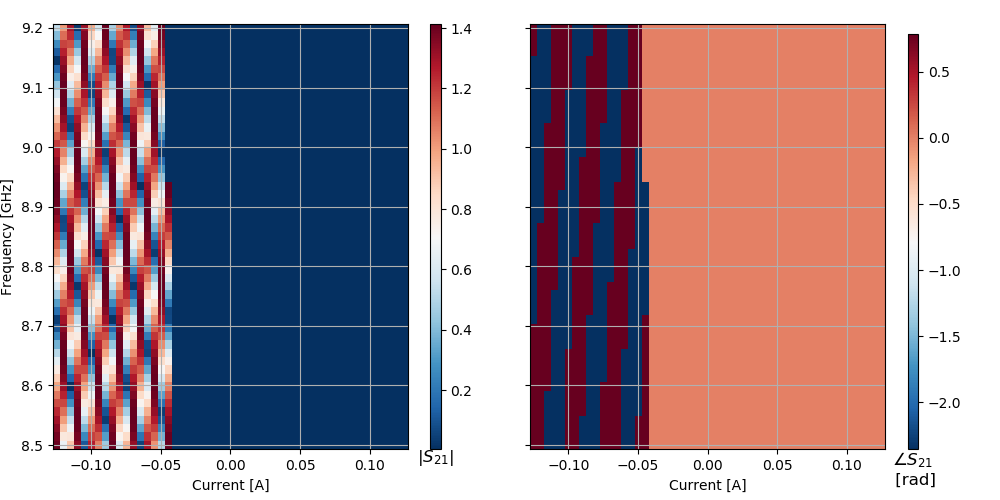

In [3]:
tts_result = TTS.launch()

In [4]:
TTS.stop()

Measurement was interrupted! 



# STS

In [6]:
from lib2.SingleToneSpectroscopy import *
currents = linspace(-.75e-4, .75e-4, 101)
voltages = linspace(-.75,1, 101)
res_limits = [4e9, 6e9]

STS = SingleToneSpectroscopy('STS', 'lol', plot_update_interval = 1, vna = [vna], src = [cur_src])
vna_parameters = {"bandwidth":500, "freq_limits":res_limits, "nop":101, "power":-20, "averages":1}
dev_params = {'vna': [vna_parameters]}

STS.set_fixed_parameters(**dev_params)
STS._src[0].set_current(currents[0])
sleep(1)
STS.set_swept_parameters({'Current [A]': (STS._src[0].set_current, currents)})
# STS.set_swept_parameters({'AWG voltage [V]': (voltage_awg.set_voltage, voltages)})

sts_result = STS.launch()

Started at:  2019-01-21 17:06:21.792428
Time left: 0 h 0 m 0.0 s, [Current [A]: 7.50e-05], average cycle time: 0.2 s           
Elapsed time: 0 h 0 m 20.48 s


In [5]:
STS.stop()

Measurement was interrupted! 

Time left: 0 h 0 m 6.86 s, [Current [A]: 2.40e-05], average cycle time: 0.2 s       

In [5]:
sts_result.visualize()

(<Figure size 1500x700 with 4 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000239EC0D05F8>,
       dtype=object),
 (<matplotlib.axes._axes.Axes at 0x23980134358>,
  <matplotlib.axes._axes.Axes at 0x23980598f28>))

In [15]:
from lib2.DispersiveRabiOscillations import *

DRO = DispersiveRabiOscillations("rabi", "lol", plot_update_interval=0.5,
            vna=[vna], q_lo=[q_lo], q_awg=[q_awg], ro_awg=[ro_awg])
vna_parameters = {"bandwidth":10, "freq_limits":[5e9]*2, "nop":10, "averages":1}
exc_frequency = 6e9
excitation_durations = linspace(0, 2000, 201)

rabi_sequence_parameters = pulse_sequence_parameters= {"awg_trigger_reaction_delay":0, "excitation_amplitude":1,
                                                "readout_duration":3000, "repetition_period":15000}
ro_awg_params =  {"calibration":MagicMock()}
q_awg_params = {"calibration":MagicMock()}
q_lo_params = {'power':-10, 'frequency':exc_frequency + 100e6}
dev_params = {'vna':[vna_parameters], 
              'ro_awg':[ro_awg_params], 
              'q_awg':[q_awg_params],
              'q_lo':[q_lo_params]}
DRO.set_fixed_parameters(rabi_sequence_parameters, **dev_params)
DRO.set_swept_parameters(excitation_durations)
#DRO.set_basis(basis)
DRO.set_ult_calib(False)

In [16]:
result = DRO.launch()

Started at:  2018-11-20 17:46:46.153761
Time left: 0 h 0 m 39.97 s, [excitation_duration: 6.00e+01], average cycle time: 0.21 s       

C:\Users\pogor\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Time left: 0 h 0 m 0.0 s, [excitation_duration: 2.00e+03], average cycle time: 0.21 s       
Elapsed time: 0 h 0 m 41.53 s


In [18]:
basis = result.get_basis()

# Joint Rabi

In [2]:
from lib2.DispersiveRabiOscillationsJoint import *

DROJ = DispersiveRabiOscillationsJoint("rabi", "lol",
            vna=[vna], q_lo=[q_lo, q_lo_2], q_awg=[q_awg, q_awg_2], ro_awg=[ro_awg], plot_update_interval=0.5, easy_fit=True)
vna_parameters = {"bandwidth":10, "freq_limits":[5e9]*2, "nop":10, "averages":1}
exc_frequency = 6e9
excitation_durations = linspace(0, 2000, 201)

rabi_sequence_parameters = pulse_sequence_parameters= {"awg_trigger_reaction_delay":0, "excitation_amplitude":1,
                                                "readout_duration":3000, "repetition_period":15000}
ro_awg_params =  {"calibration":MagicMock()}
q_awg_params = {"calibration":MagicMock()}
q_lo_params = {'power':-10, 'frequency':exc_frequency + 100e6}
dev_params = {'vna':[vna_parameters], 
              'ro_awg':[ro_awg_params], 
              'q_awg':[q_awg_params, q_awg_params],
              'q_lo':[q_lo_params, q_lo_params]}
DROJ.set_fixed_parameters(rabi_sequence_parameters, **dev_params)
DROJ.set_swept_parameters(excitation_durations)
#DRO.set_basis(basis)
DROJ.set_ult_calib(False)

In [4]:
droj_result.get_betas()

((-7.584621733423947e-09+3.4596915328470114e-09j),
 (0.5000586655083248+0.5000598562870332j),
 (0.49994139917905517+0.4999402040342642j),
 (-9.304001906805738e-11+3.943796090626318e-09j))

In [ ]:
DROJ.stop()

In [5]:
droj_result.visualize()

(<Figure size 1500x700 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x000002BC61E36668>,
       dtype=object),
 (None, None))

Traceback (most recent call last):
  File "C:\Users\Ultmessia\Anaconda3\lib\site-packages\matplotlib\mathtext.py", line 2515, in parse
    result = self._expression.parseString(s)
  File "C:\Users\Ultmessia\Anaconda3\lib\site-packages\pyparsing.py", line 1632, in parseString
    raise exc
  File "C:\Users\Ultmessia\Anaconda3\lib\site-packages\pyparsing.py", line 1622, in parseString
    loc, tokens = self._parse( instring, 0 )
  File "C:\Users\Ultmessia\Anaconda3\lib\site-packages\pyparsing.py", line 1529, in _parseCache
    value = self._parseNoCache(instring, loc, doActions, callPreParse)
  File "C:\Users\Ultmessia\Anaconda3\lib\site-packages\pyparsing.py", line 1379, in _parseNoCache
    loc,tokens = self.parseImpl( instring, preloc, doActions )
  File "C:\Users\Ultmessia\Anaconda3\lib\site-packages\pyparsing.py", line 3717, in parseImpl
    return self.expr._parse( instring, loc, doActions, callPreParse=False )
  File "C:\Users\Ultmessia\Anaconda3\lib\site-packages\pyparsing.py", l

In [3]:
droj_result = DROJ.launch()

Started at:  2018-12-10 15:52:28.775716
Time left: 0 h 0 m 37.53 s, [excitation_duration: 2.50e+02], average cycle time: 0.21 s       Fit failed unexpectedly: Singular matrix
[0.04946950299855734, 0.04946950299855734, 0.04946950299855734, 0.04946950299855734, 0.04946950299855734, 0.04946950299855734, 0.04946950299855734, 0.04946950299855734, 0.7390481805386263, 0.7390481805386263, 46.435766692581026, 0.7390481805386263, 0.7390481805386263, 46.435766692581026] ([-0.09893900599711468, -0.09893900599711468, -0.09893900599711468, -0.09893900599711468, -0.09893900599711468, -0.09893900599711468, -0.09893900599711468, -0.09893900599711468, 1e-07, 1e-07, 6.283185307179586e-06, 1e-07, 1e-07, 6.283185307179586e-06], [0.09893900599711468, 0.09893900599711468, 0.09893900599711468, 0.09893900599711468, 0.09893900599711468, 0.09893900599711468, 0.09893900599711468, 0.09893900599711468, 1.0, 1.0, 62.83185307179586, 1.0, 1.0, 62.83185307179586])
Fit failed unexpectedly: Singular matrix


C:\Users\pogor\YandexDisk\Ustinov internship\Measurement-automation\lib2\DispersiveRabiOscillationsJoint.py:45: RuntimeWarning: invalid value encountered in sqrt
  omega_r_2 = sqrt(omega_r ** 2 - (1 / tau_r) ** 2)


Time left: 0 h 0 m 36.97 s, [excitation_duration: 2.90e+02], average cycle time: 0.22 s       Fit failed unexpectedly: Singular matrix
[-3.81999541e-06 -3.81999536e-06  5.00471419e-01  5.00470544e-01
  4.99529281e-01  4.99538745e-01 -3.76352622e-07 -1.95874487e-06
  7.68426472e-06  7.68426472e-06  1.00116682e+01  1.06114991e-05
  1.06114991e-05  9.98827288e+00] ([-1.8768887533689473, -1.8768887533689473, -1.8768887533689473, -1.8768887533689473, -1.8768887533689473, -1.8768887533689473, -1.8768887533689473, -1.8768887533689473, 1e-07, 1e-07, 6.283185307179586e-06, 1e-07, 1e-07, 6.283185307179586e-06], [1.8768887533689473, 1.8768887533689473, 1.8768887533689473, 1.8768887533689473, 1.8768887533689473, 1.8768887533689473, 1.8768887533689473, 1.8768887533689473, 1.0, 1.0, 62.83185307179586, 1.0, 1.0, 62.83185307179586])
Fit failed unexpectedly: Singular matrix
Time left: 0 h 0 m 36.5 s, [excitation_duration: 3.10e+02], average cycle time: 0.22 s       Fit failed unexpectedly: Singular mat

C:\Users\pogor\YandexDisk\Ustinov internship\Measurement-automation\lib2\VNATimeResolvedDispersiveMeasurement1D.py:81: RuntimeWarning: invalid value encountered in sqrt
  return result, sqrt(diag(sigma ** 2 * inv(result.jac.T.dot(result.jac))))


Time left: 0 h 0 m 22.23 s, [excitation_duration: 9.70e+02], average cycle time: 0.22 s       Fit failed unexpectedly: Singular matrix
[-0.10292136 -0.10292136 -0.35111605 -0.35068272  0.38818663  0.3878914
  0.38696925  0.39532228  1.          1.         45.40813002  1.
  1.         44.92723444] ([-2.0196930420352066, -2.0196930420352066, -2.0196930420352066, -2.0196930420352066, -2.0196930420352066, -2.0196930420352066, -2.0196930420352066, -2.0196930420352066, 1e-07, 1e-07, 6.283185307179586e-06, 1e-07, 1e-07, 6.283185307179586e-06], [2.0196930420352066, 2.0196930420352066, 2.0196930420352066, 2.0196930420352066, 2.0196930420352066, 2.0196930420352066, 2.0196930420352066, 2.0196930420352066, 1.0, 1.0, 62.83185307179586, 1.0, 1.0, 62.83185307179586])
Fit failed unexpectedly: Singular matrix
Time left: 0 h 0 m 22.01 s, [excitation_duration: 9.80e+02], average cycle time: 0.22 s       Fit failed unexpectedly: Singular matrix
[-0.11331603 -0.11331603  0.21358723  0.21359434 -0.17713868 

Measurement was interrupted! 

Time left: 0 h 5 m 40.08 s, [excitation_duration: 3.20e+02], average cycle time: 2.02 s       